In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
 df = pd.read_csv('Volve P-12_DatesCorrected.txt',index_col=0, parse_dates = True)

In [ ]:
domain_feat = ['ON_STREAM_HRS',
              'AVG_DOWNHOLE_PRESSURE',
              'AVG_ANNULUS_PRESS',
              'AVG_CHOKE_SIZE_P in percentage',
              'AVG_WHP_P']

In [ ]:
target = 'BORE_OIL_VOL'
X = df[domain_feat]
y = df[target]
train_length = int(len(df) * 0.8)

X_train , y_train = X.iloc[:train_length,:] , y[:train_length]

X_test , y_test = X.iloc[train_length:, :] , y[train_length:]

X_train.shape, X_test.shape

((2632, 5), (659, 5))

In [ ]:
CNN_data = df[domain_feat].copy()

In [ ]:
def prepare_multivariate_data_for_lstm(data, target_col, n_in=1, n_out=1, train_split=0.8):
    """
    Preprocesses a multivariate time series dataset for use in an LSTM model.

    Args:
        df (pandas.DataFrame): Input dataframe with time series data.
        target_col (str): Name of the target column to be predicted.
        n_in (int): Number of past time steps to use as input for each prediction (default: 1).
        n_out (int): Number of future time steps to predict (default: 1).
        train_split (float): Proportion of data to use for training (default: 0.8).

    Returns:
        tuple: X_train, y_train, X_test, y_test, scaler, n_features
    """
    # Ensure that the dataframe is sorted by time
    data = data.sort_index()

    # Get the names of all columns in the dataframe
    all_cols = data.columns.tolist()

    # Ensure that the target column is in the dataframe
    assert target_col in all_cols, f"Target column '{target_col}' not found in dataframe."

    # Remove the target column from the list of feature columns
    feature_cols = [col for col in all_cols if col != target_col]

    # Scale the data using a MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(data[feature_cols])
    y_scaled = scaler.fit_transform(data[[target_col]])

    # Split the data into training and test sets
    n_train = int(len(data) * train_split)
    train_X_scaled, test_X_scaled = X_scaled[:n_train, :], X_scaled[n_train:, :]
    train_y_scaled, test_y_scaled = y_scaled[:n_train, :], y_scaled[n_train:, :]

    # Define the training and test data as numpy arrays
    X_train = []
    y_train = []
    for i in range(n_in, len(train_X_scaled)):
        X_train.append(train_X_scaled[i-n_in:i, :])
        y_train.append(train_y_scaled[i:i+n_out, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test = []
    y_test = []
    for i in range(n_in, len(test_X_scaled)):
        X_test.append(test_X_scaled[i-n_in:i, :])
        y_test.append(test_y_scaled[i:i+n_out, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Determine the number of features
    n_features = X_train.shape[2]

    return X_train, y_train, X_test, y_test, scaler, n_features

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
data = CNN_data
target_col = 'BORE_OIL_VOL'
n_in = 25
n_out = 1


X_train, y_train, X_test, y_test, scaler, n_features = prepare_multivariate_data_for_lstm(df, target_col, n_in, n_out, train_split=0.8)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2607, 25, 13), (2607, 1), (634, 25, 13), (634, 1))

In [ ]:
# define the model
def define_CNN(input_shape):
    np.random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    # compile the model
    optimizer = Adam(lr=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [ ]:
sequence_length = n_in
num_features = n_features
input_shape=(sequence_length, num_features)
CNN_model = define_CNN(input_shape)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
CNN_model.fit(X_train, y_train)

82/82 [==============================] - 2s 13ms/step - loss: 0.0302 - mae: 0.1170


In [ ]:
CNN_test = CNN_model.predict(X_test)
CNN_train = CNN_model.predict(X_train)


CNN_train = scaler.inverse_transform(CNN_train)
CNN_test = scaler.inverse_transform(CNN_test)
y_train =scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


82/82 [==============================] - 0s 2ms/step


In [ ]:
mae(CNN_test, y_test)

199.43004747745744

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(CNN_test, y_test, squared = False)

251.65153278395314

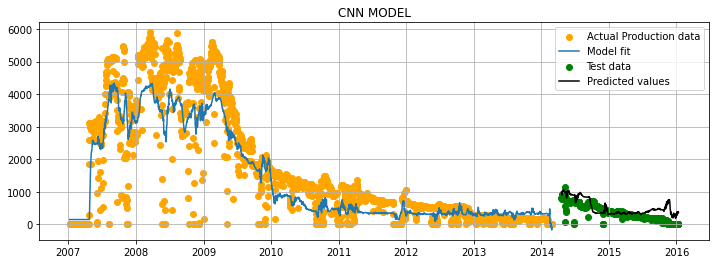

In [ ]:
plt.figure(figsize=(12,4))

plt.scatter(df.index[:train_length-n_in] , y_train, color='orange', label = "Actual Production data")
plt.plot(df.index[:train_length-n_in] , CNN_train, label = "Model fit")

plt.scatter(df.index[train_length+n_in:] , y_test, color='green', label = "Test data")
plt.plot(df.index[train_length+n_in:] , CNN_test, color='black', label = "Predicted values")


# plt.axvline(df.index[train_length+n_in], color='red')
plt.title('CNN MODEL')
plt.legend(loc="upper right")

plt.grid()

In [ ]:
# import joblib

In [ ]:
# filename = 'CNN_model1.joblib'
# joblib.dump(CNN_model, filename)